In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install kaggle
# !pip3 install umap-learn
# !pip install optuna

In [3]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c house-prices-advanced-regression-techniques
# !unzip /content/house-prices-advanced-regression-techniques.zip -d /content/

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import norm
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import statsmodels.api as sm
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import datetime
from datetime import datetime
from IPython.display import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120

## 1)  Analysis

1) Loading the DataFrames

In [11]:
train = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')

2) DataFrame information

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

3) Building a heat map for features and analysis target 

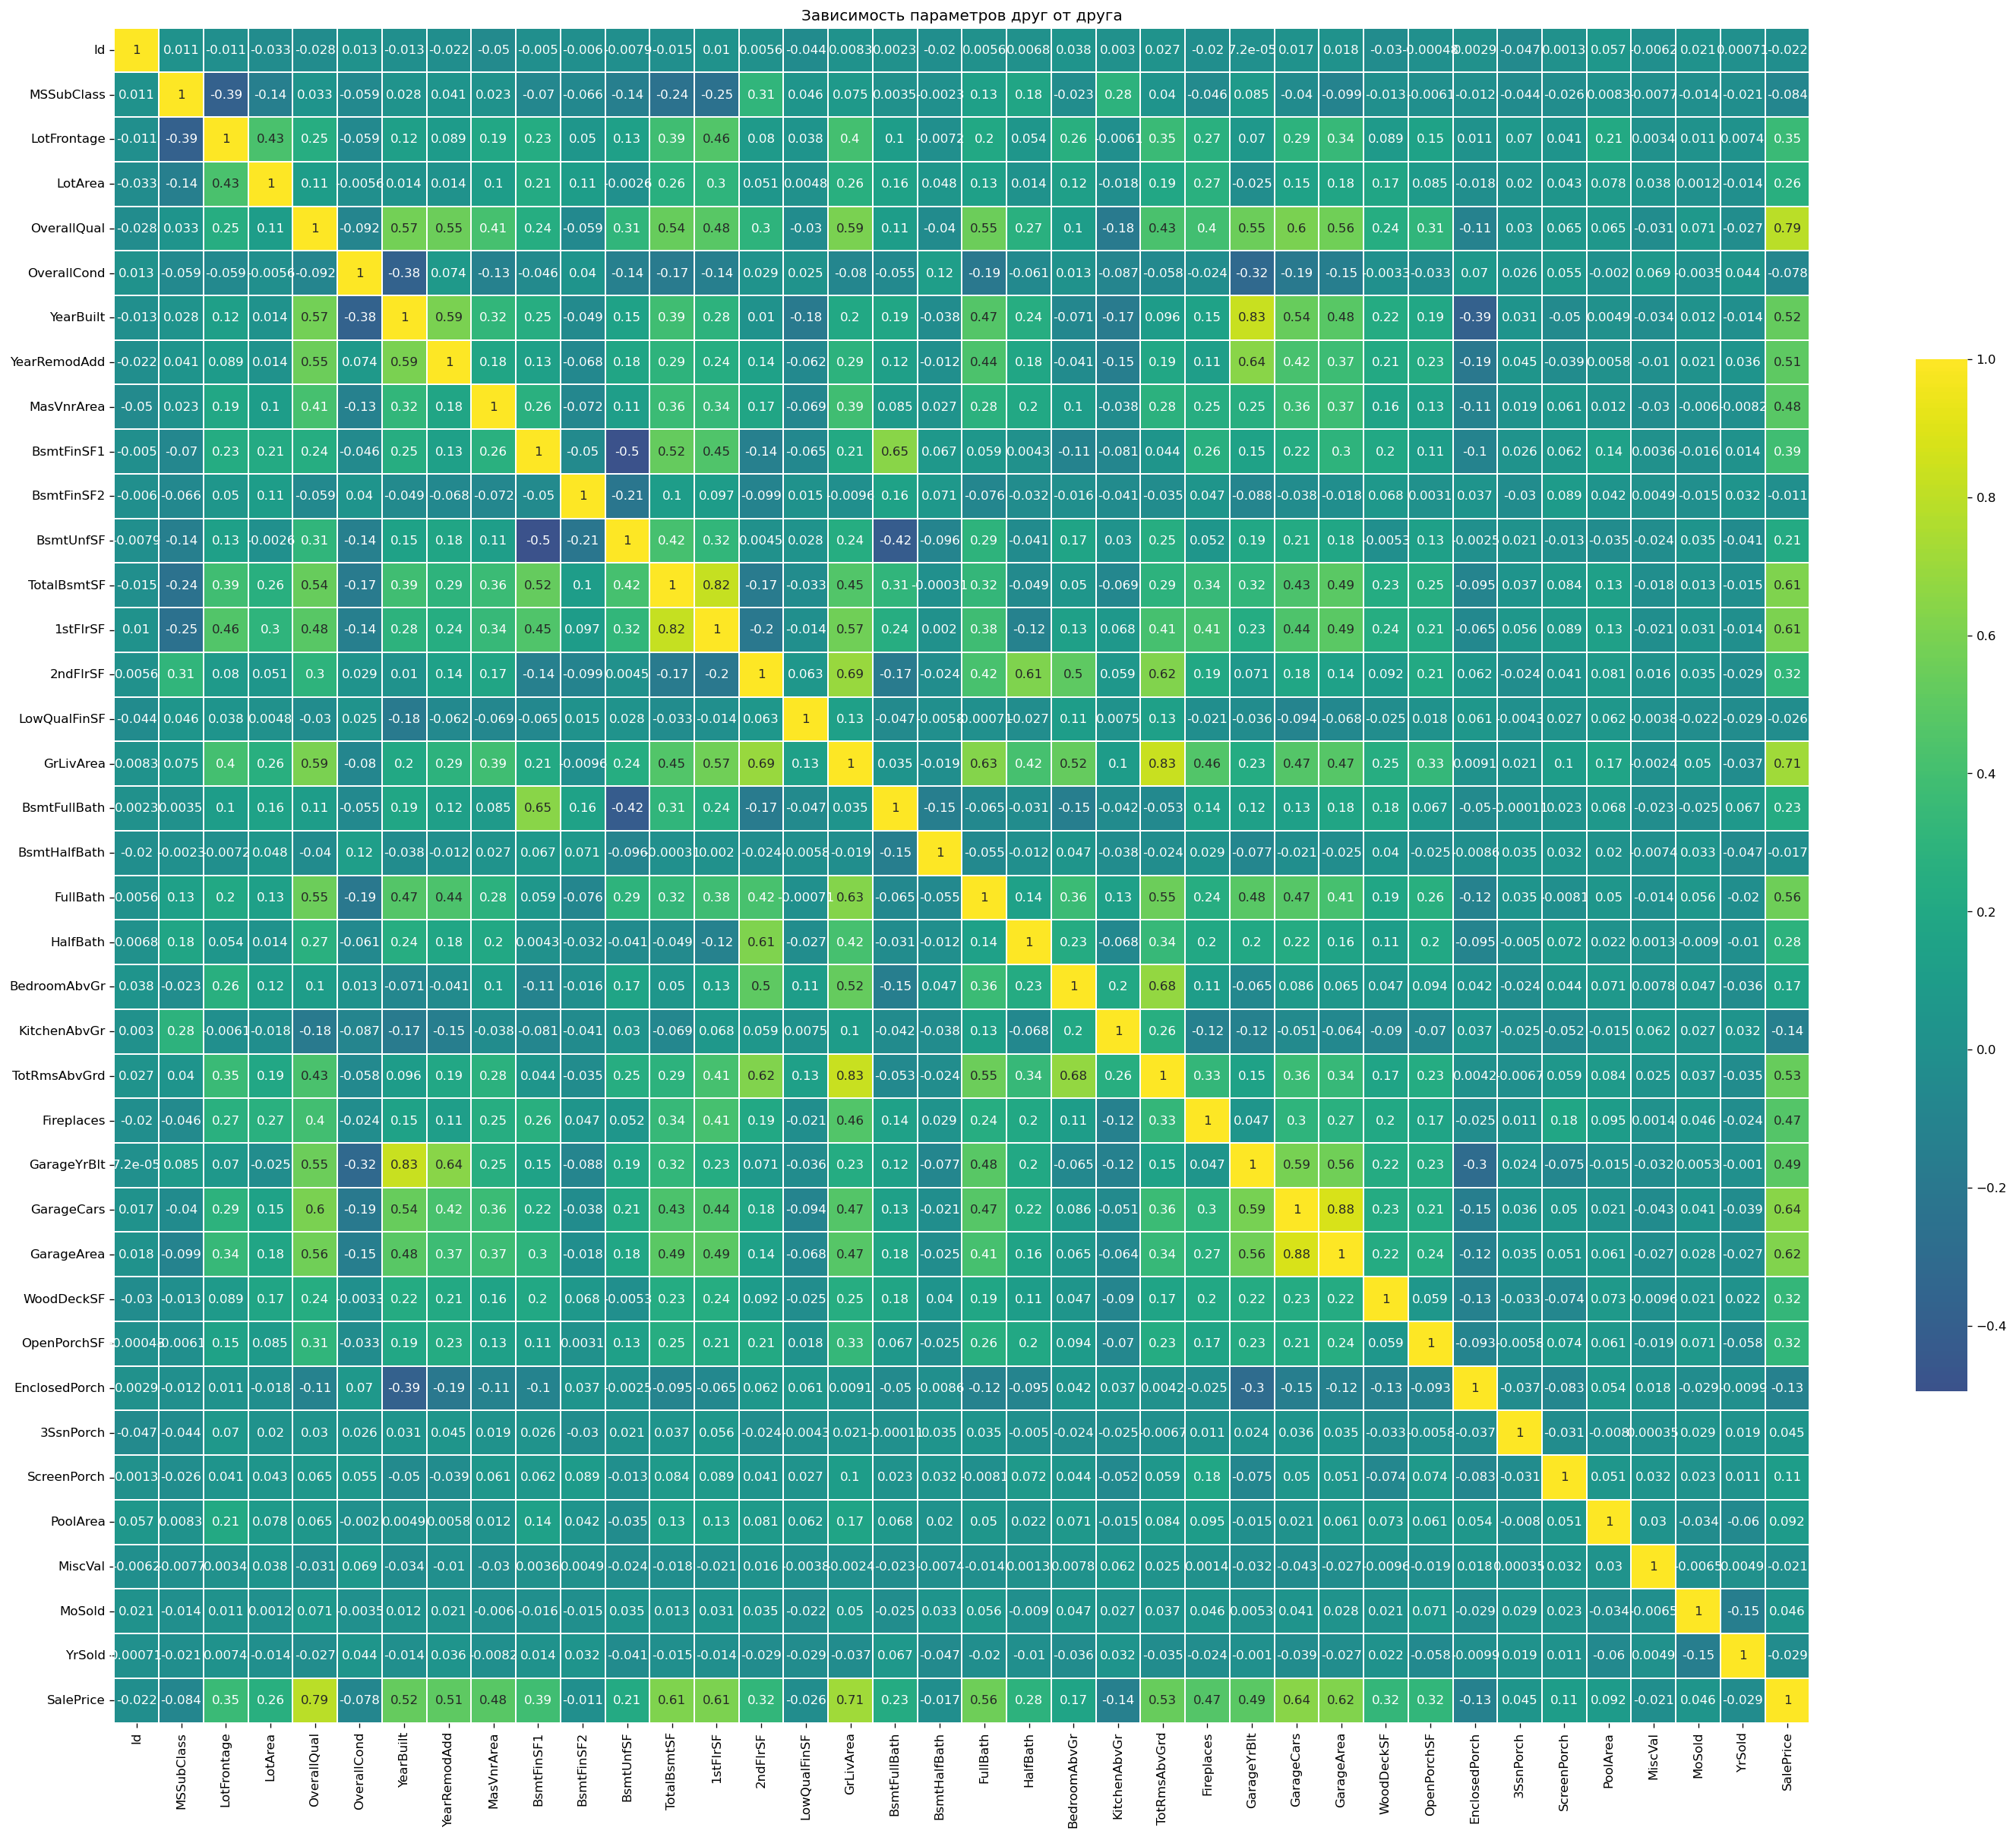

In [14]:
plt.subplots(figsize=(30, 30))
plt.title('Зависимость параметров друг от друга', fontsize = 12)
sns.heatmap(train.corr(), vmax=1, annot=True, cmap = 'viridis', linewidths=1, square=True, center=0,cbar_kws={"shrink": .5});

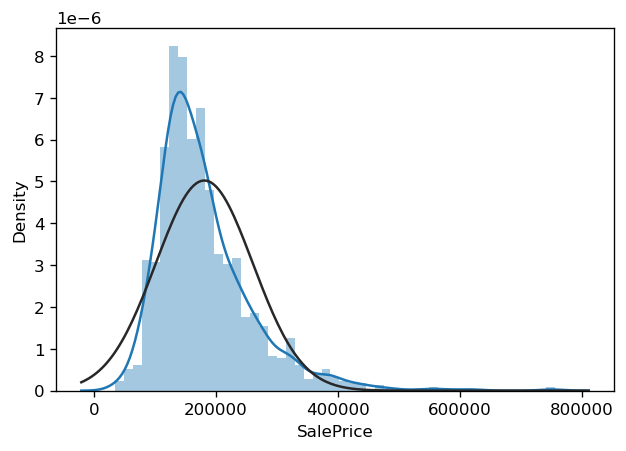

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(train.SalePrice, kde = True, hist=True, fit = norm)

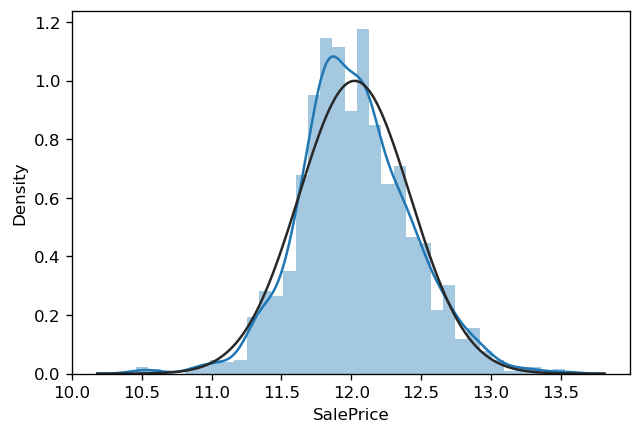

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(np.log1p(train.SalePrice), kde = True, hist=True, fit = norm);

## 2) Feature engineering

1) Creating common base

In [ ]:
train = train.reset_index(drop=True)

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [ ]:
target = train['SalePrice'].reset_index(drop=True)

In [12]:
features = pd.concat([train.drop('SalePrice', axis = 1),test]).reset_index().drop('index', axis=1)

2) Changing data types

In [14]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].apply(str)
features['MoSold'] = features['MoSold'].apply(str)

3) Fill the NaN for categorical features and remove non-informative features

In [15]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.fillna(x.mode()[0]))

In [16]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    features[col] = features[col].fillna('None')

In [18]:
features['Alley'] = features['Alley'].fillna('None')
features['Fence'] = features['Fence'].fillna('None')
features['MiscFeature'] = features['MiscFeature'].fillna('None')
features['MasVnrType'] = features['MasVnrType'].fillna('None')
features['FireplaceQu'] = features['FireplaceQu'].fillna('None')
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [19]:
features = features.drop(['Id','PoolQC','Street','Utilities'], axis = 1)

In [20]:
features['FullBath'].value_counts()

2    1530
1    1309
3      64
0      12
4       4
Name: FullBath, dtype: int64

4) Fill the Nan for numeric features

In [21]:
for i in features.select_dtypes(exclude = object).columns:
    features[i] = features[i].fillna(0)

In [22]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Alley          2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   LotConfig      2919 non-null   object 
 8   LandSlope      2919 non-null   object 
 9   Neighborhood   2919 non-null   object 
 10  Condition1     2919 non-null   object 
 11  Condition2     2919 non-null   object 
 12  BldgType       2919 non-null   object 
 13  HouseStyle     2919 non-null   object 
 14  OverallQual    2919 non-null   int64  
 15  OverallCond    2919 non-null   int64  
 16  YearBuilt      2919 non-null   int64  
 17  YearRemodAdd   2919 non-null   int64  
 18  RoofStyl

5) Minimizing data outliers

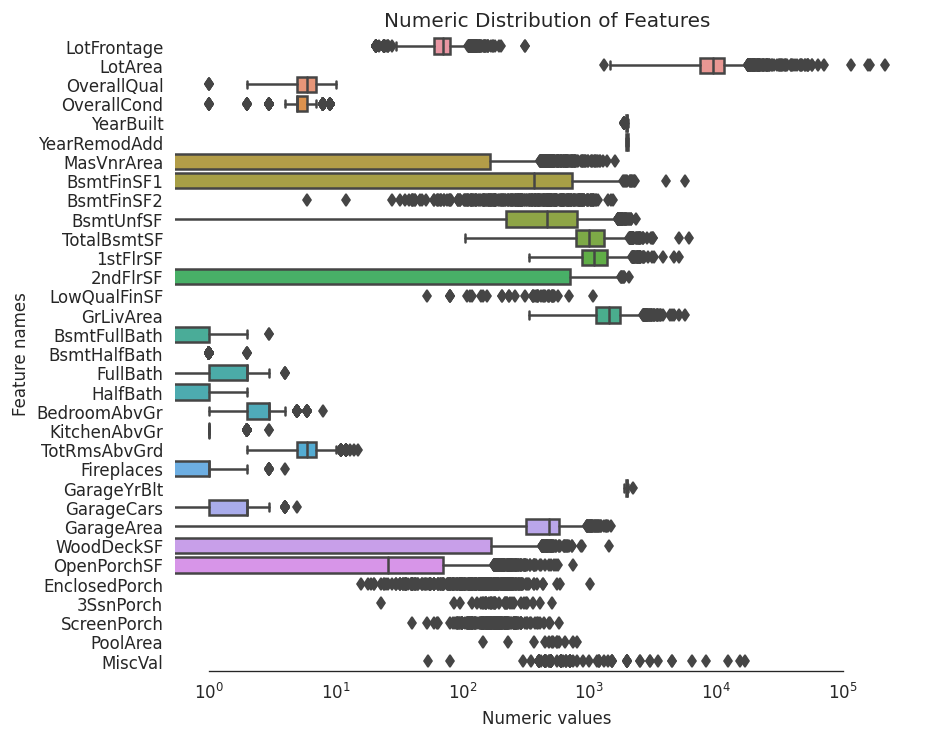

In [23]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
sns.boxplot(data=features.select_dtypes(exclude = object),orient = 'h', ax=ax)
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [24]:
skew_feature = features.select_dtypes(exclude = object).skew()
skew_feature_index = skew_feature.index[skew_feature>0.5]

In [25]:
for i in skew_feature_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

6) Add new features

In [26]:
features['LotSF'] = features['LotFrontage'] + features['LotArea']
features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)
features['Total_Home_Quality'] = features['OverallQual'] + features['OverallCond']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])
features['Total_Bathrooms'] = features['FullBath'] + features['HalfBath'] + features['BsmtFullBath'] + features['BsmtHalfBath']

In [27]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
features['garageage'] = features['GarageYrBlt'].apply(lambda x: 1 if x > 0 else 0)

7) Removing extra columns

In [28]:
features = features.loc[:,~features.columns.duplicated()]

## 3) Clustering

In [31]:
features_num = StandardScaler().fit_transform(features.select_dtypes(exclude = 'object'))

In [32]:
pca = PCA(n_components=3)
tsne = TSNE(n_components=3, perplexity=15, random_state=42)
umap = UMAP(n_components=3, n_neighbors=30, random_state =42)

In [33]:
X_pca = pca.fit_transform(features_num)
X_tsne = tsne.fit_transform(features_num)
X_umap = umap.fit_transform(features_num)

Text(0.5, 1.0, 'UMAP')

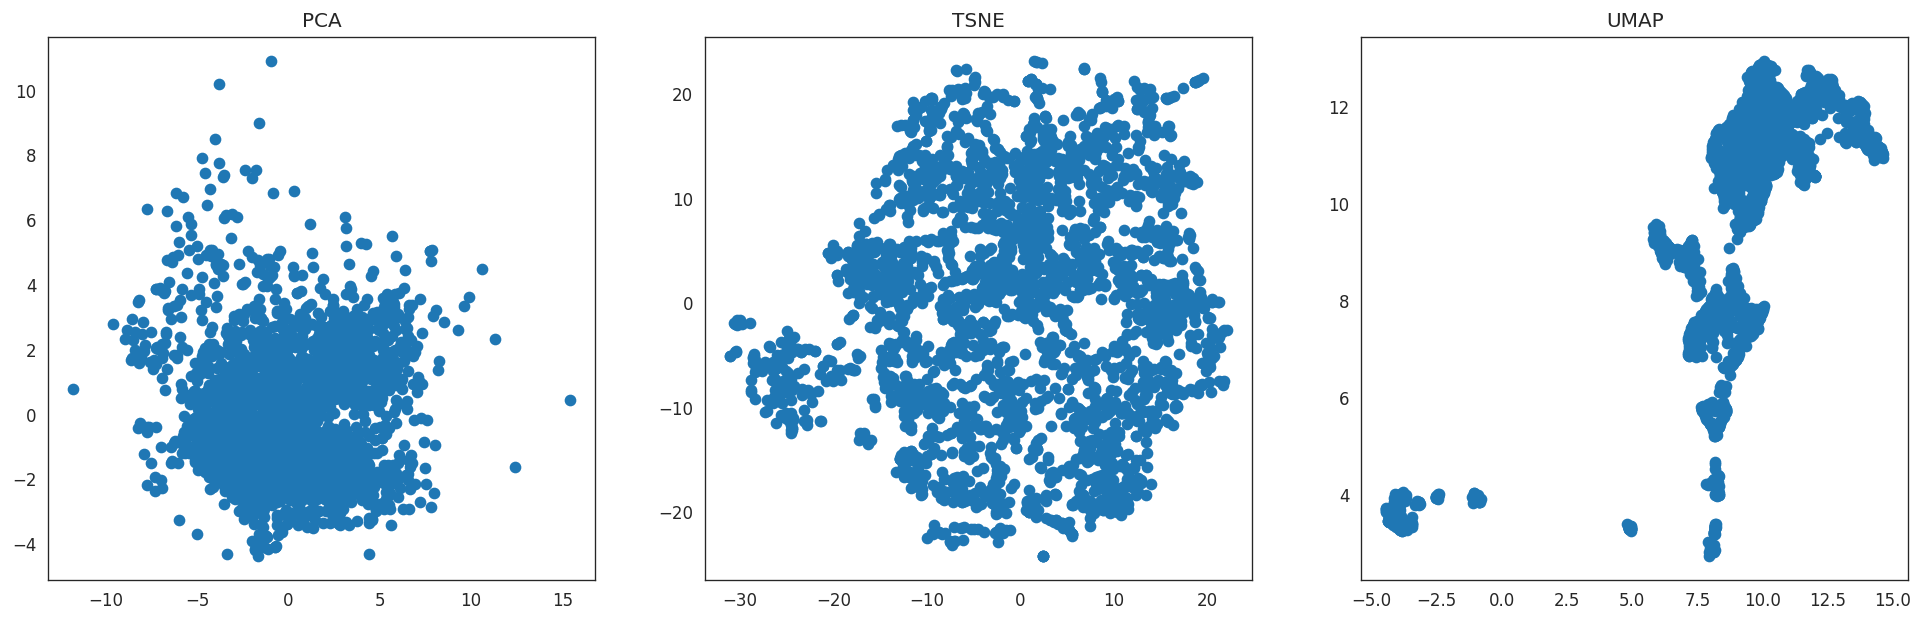

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.scatter(X_pca[:, 0], X_pca[:, 1])
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax3.scatter(X_umap[:, 0], X_umap[:, 1])

ax1.set_title('PCA')
ax2.set_title('TSNE')
ax3.set_title('UMAP')

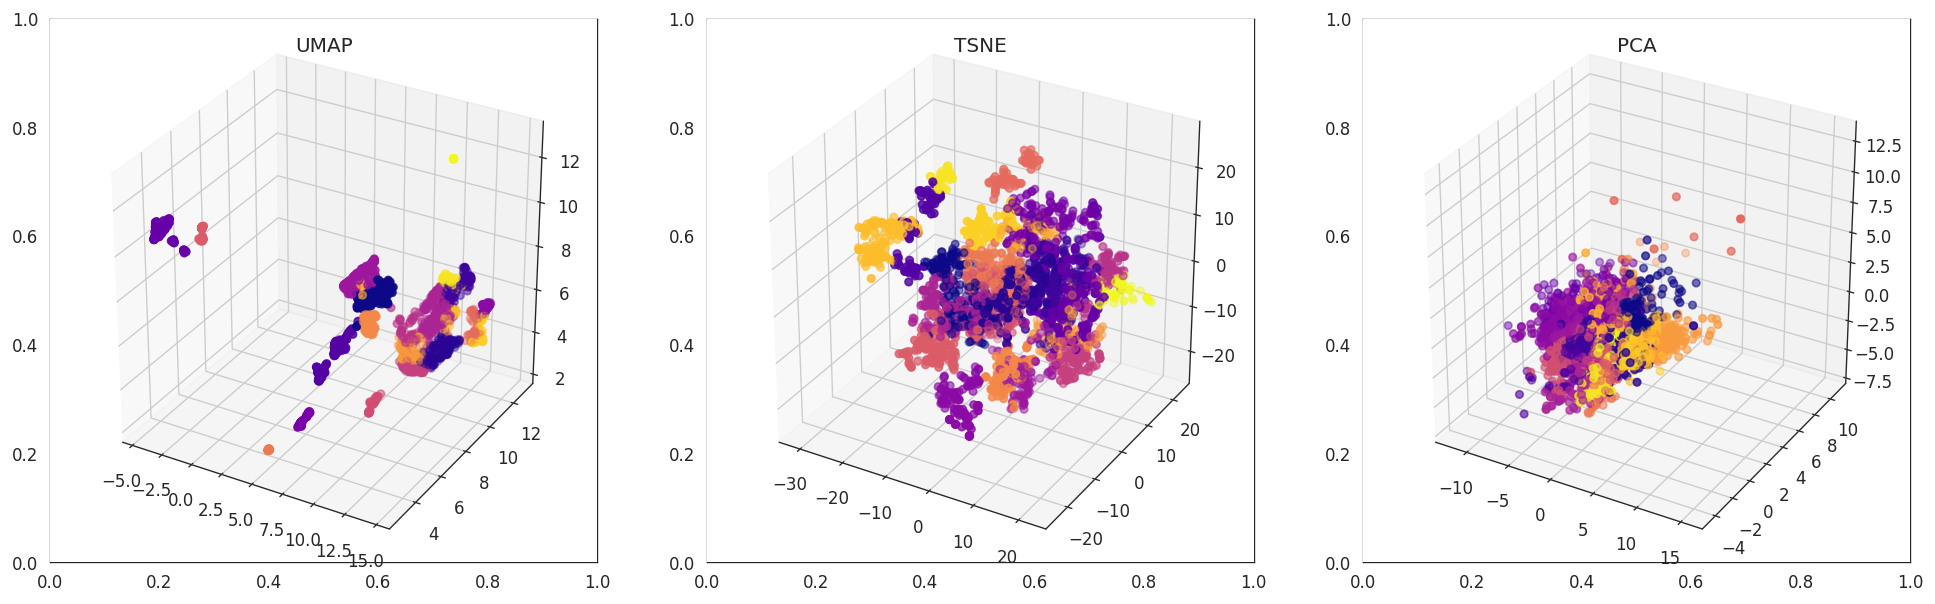

In [35]:
ag = AgglomerativeClustering(22)
ag_umap = ag.fit_predict(X_umap)
ag_tsne = ag.fit_predict(X_tsne)
ag_pca = ag.fit_predict(X_pca)
# Draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
ax1.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c = ag_umap, cmap='plasma')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = ag_tsne, cmap='plasma')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = ag_pca, cmap='plasma')
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

In [36]:
features['Cluster'] = ag_pca

## 4) Feature encoding

In [37]:
features = pd.get_dummies(features).reset_index(drop=True)

## 5) Prepairing samples

In [39]:
X = features.iloc[:len(target), :]
X_KAGGLE = features.iloc[len(target):, :]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,target, random_state=42, test_size=.25)

## 6) Prepairing models

In [54]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmsle(model, X=X, y=target):
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))

kf = KFold(n_splits=5,shuffle=True, random_state=42)

In [51]:
def objective_lgbm(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
              'metric': 'rmse', 
              'random_state': 42,
              'n_estimators': 10000,
              # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
              # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
              'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
              'learning_rate': trial.suggest_categorical('learning_rate',[0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
              'max_depth': trial.suggest_categorical('max_depth', [-1,10,20,30]),
              'num_leaves' : trial.suggest_int('num_leaves', 2, 300),
              'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
              'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**params)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_test)
    
    metric = rmse(y_test, preds)
    
    return metric

In [53]:
%%time
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=10)
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)
print('Best score:', study_lgbm.best_trial.value)

[I 2022-04-21 02:15:52,154] A new study created in memory with name: no-name-a120f889-4eae-4a71-bed8-20412ecf836f
[I 2022-04-21 02:15:55,127] Trial 0 finished with value: 0.14196893326495214 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 73, 'min_child_samples': 170, 'min_data_per_groups': 14}. Best is trial 0 with value: 0.14196893326495214.
[I 2022-04-21 02:15:56,868] Trial 1 finished with value: 0.14623082180559177 and parameters: {'colsample_bytree': 0.35, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': -1, 'num_leaves': 174, 'min_child_samples': 247, 'min_data_per_groups': 78}. Best is trial 0 with value: 0.14196893326495214.
[I 2022-04-21 02:15:59,333] Trial 2 finished with value: 0.1374992302692014 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.65, 'learning_rate': 0.03, 'max_depth': -1, 'num_leaves': 252, 'min_child_samples': 99, 'min_data_per_groups': 80}. Best is trial 2 with value: 0.1374992

Number of finished trials: 10
Best trial: {'colsample_bytree': 0.5, 'subsample': 0.65, 'learning_rate': 0.015, 'max_depth': -1, 'num_leaves': 218, 'min_child_samples': 36, 'min_data_per_groups': 19}
Best score: 0.1275520620210304
CPU times: user 52.6 s, sys: 1.09 s, total: 53.7 s
Wall time: 34.3 s


In [55]:
params_lgbm = study_lgbm.best_trial.params

In [56]:
def objective_xgbr(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
              'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.04,0.05,0.08]),
              'n_estimators': trial.suggest_categorical('n_estimators', [1000,1500,2000,2500,3000,4000,10000,15000]),
              'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,20,30]),
              'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
              'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
              'objective' : trial.suggest_categorical('objective', ['reg:squarederror'])
    }
    model = XGBRegressor(**params)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_test)
    
    metric = rmse(y_test, preds)
    
    return metric

In [57]:
%%time
study_xgbr = optuna.create_study(direction='minimize')
study_xgbr.optimize(objective_xgbr, n_trials=10)
print('Number of finished trials:', len(study_xgbr.trials))
print('Best trial:', study_xgbr.best_trial.params)
print('Best score:', study_xgbr.best_trial.value)

[I 2022-04-21 02:16:49,901] A new study created in memory with name: no-name-80ffc039-7758-4717-a135-61fa71375c19
[I 2022-04-21 02:17:31,317] Trial 0 finished with value: 0.12574939547373512 and parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.008, 'n_estimators': 3000, 'max_depth': 11, 'subsample': 0.5, 'random_state': 48, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.12574939547373512.
[I 2022-04-21 02:17:48,641] Trial 1 finished with value: 0.12297472380545763 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 7, 'subsample': 0.4, 'random_state': 24, 'objective': 'reg:squarederror'}. Best is trial 1 with value: 0.12297472380545763.
[I 2022-04-21 02:17:55,095] Trial 2 finished with value: 0.12585672100570064 and parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.04, 'n_estimators': 1500, 'max_depth': 5, 'subsample': 0.5, 'random_state': 24, 'objective': 'reg:squarederror'}. Best is trial 1 with value: 0

Number of finished trials: 10
Best trial: {'colsample_bytree': 0.7, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 7, 'subsample': 0.4, 'random_state': 24, 'objective': 'reg:squarederror'}
Best score: 0.12297472380545763
CPU times: user 4min 18s, sys: 1.08 s, total: 4min 19s
Wall time: 4min 26s


In [58]:
params_xgbr = study_xgbr.best_trial.params

In [59]:
def objective_gbr(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    params = {
        'loss': trial.suggest_categorical('loss', ['ls', 'lad','huber','quantile']),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.2,0.3]),
        'max_depth': trial.suggest_int('max_depth', 1, 10), 
    }

    model = GradientBoostingRegressor(**params)  
    
    model.fit(X_train,y_train)
    
    preds = model.predict(X_test)
    
    metric = rmse(y_test, preds)
    
    return metric

In [60]:
%%time
study_gbr = optuna.create_study(direction='minimize')
study_gbr.optimize(objective_gbr, n_trials=20)
print('Number of finished trials:', len(study_gbr.trials))
print('Best trial:', study_gbr.best_trial.params)
print('Best score:', study_gbr.best_trial.value)

[I 2022-04-21 02:21:26,409] A new study created in memory with name: no-name-4a17dbef-91c7-4cac-b1c0-7851ae655ad2
[I 2022-04-21 02:21:30,596] Trial 0 finished with value: 0.221561074511933 and parameters: {'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 0 with value: 0.221561074511933.
[I 2022-04-21 02:21:35,253] Trial 1 finished with value: 0.2680631999664166 and parameters: {'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 8}. Best is trial 0 with value: 0.221561074511933.
[I 2022-04-21 02:21:38,175] Trial 2 finished with value: 0.2268273559616067 and parameters: {'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 0 with value: 0.221561074511933.
[I 2022-04-21 02:21:39,310] Trial 3 finished with value: 0.24016046309153777 and parameters: {'loss': 'ls', 'learning_rate': 0.01, 'max_depth': 3}. Best is trial 0 with value: 0.221561074511933.
[I 2022-04-21 02:21:40,102] Trial 4 finished with value: 0.12819430680778524 and parameters: {'loss': '

Number of finished trials: 20
Best trial: {'loss': 'ls', 'learning_rate': 0.1, 'max_depth': 2}
Best score: 0.12819430680778524
CPU times: user 39.8 s, sys: 103 ms, total: 39.9 s
Wall time: 39.8 s


In [61]:
params_gbr = study_gbr.best_trial.params

In [62]:
xgb = XGBRegressor()
lgbm = LGBMRegressor()
gbr = GradientBoostingRegressor()
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=np.arange(14.5, 15.6, 0.1), cv=kf))
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
stack_gen = StackingCVRegressor(regressors=(xgb, lgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgb,
                                use_features_in_secondary=True)

In [63]:
models = {'RidgeCV': ridge,
          'SupportVectorRegressor': svr, 
          'GradientBoostingRegressor': gbr, 
          'LightGBMRegressor': lgbm, 
          'XGBoostRegressor': xgb,
          'RandomForestRegressor': rf,
          'StackingCVRegressor': stack_gen}

## 7) Training models

In [64]:
scores = {}

for name, model in models.items():
    start = datetime.now()
        print(f'{start} Starting: {name}')

    if name=='StackingCVRegressor':
        model.fit(np.array(X), np.array(target))
        score = cv_rmsle(model=model,X=np.array(X),y=np.array(target))
        scores[name] = (score.mean(), score.std())
    else:
        model.fit(X,target)
        score = cv_rmsle(model=model)
        scores[name] = (score.mean(), score.std())

    end = datetime.now()

    print(f'{end} Finished {name} in {(end-start).total_seconds()}')
    print(f'{datetime.now()} {name} RMSE: {scores[name][0]} / Std: {scores[name][1]}')

2022-04-21 02:22:32.786847 Starting: RidgeCV
2022-04-21 02:22:55.788823 Finished RidgeCV in 23.001976
2022-04-21 02:22:55.789861 RidgeCV RMSE: 0.13340819328683756 / Std: 0.02705844073142116
2022-04-21 02:22:55.790228 Starting: SupportVectorRegressor
2022-04-21 02:22:59.664617 Finished SupportVectorRegressor in 3.874389
2022-04-21 02:22:59.664817 SupportVectorRegressor RMSE: 0.12858346725013253 / Std: 0.029765849868408
2022-04-21 02:22:59.664868 Starting: GradientBoostingRegressor
2022-04-21 02:23:07.171616 Finished GradientBoostingRegressor in 7.506748
2022-04-21 02:23:07.171817 GradientBoostingRegressor RMSE: 0.13490628093255147 / Std: 0.01954491196149413
2022-04-21 02:23:07.171868 Starting: LightGBMRegressor
2022-04-21 02:23:10.343720 Finished LightGBMRegressor in 3.171852
2022-04-21 02:23:10.343915 LightGBMRegressor RMSE: 0.13765076611625146 / Std: 0.016006863917609596
2022-04-21 02:23:10.344716 Starting: XGBoostRegressor
[02:23:10] WARNING: /workspace/src/objective/regression_obj.c

In [65]:
scores

{'GradientBoostingRegressor': (0.13490628093255147, 0.01954491196149413),
 'LightGBMRegressor': (0.13765076611625146, 0.016006863917609596),
 'RandomForestRegressor': (0.14543408923808157, 0.01631647950458093),
 'RidgeCV': (0.13340819328683756, 0.02705844073142116),
 'StackingCVRegressor': (0.1265798803023152, 0.015389140678909117),
 'SupportVectorRegressor': (0.12858346725013253, 0.029765849868408),
 'XGBoostRegressor': (0.1361992010094804, 0.01634471103637574)}

## 8) Stacking

In [152]:
def blended_predictions(X):
    return ((0.15 * ridge.predict(X)) + \
            (0.15 * svr.predict(X)) + \
            (0.3 * xgb.predict(X)) + \
            (0.3 * lgbm.predict(X)) + \
            (0.1 * stack_gen.predict(np.array(X))))

In [153]:
blended_score = rmse(y_train, blended_predictions(X_train))
print('Blended Prediction RMSE: {}'.format(blended_score))

Blended Prediction RMSE: 0.07082321619982149


## 9) Predictions and prepairing file for Kaggle

In [154]:
submission = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")

In [155]:
pred = np.expm1(blended_predictions(X_KAGGLE))

In [156]:
test_kaggle = pd.DataFrame(index = submission['Id'], data = pred, columns = ['SalePrice'])

In [158]:
suffix = datetime.now().strftime("%y%m%d_%H%M%S")

In [159]:
test_kaggle.to_csv(f'./result_{suffix}.csv')

## 10) Result

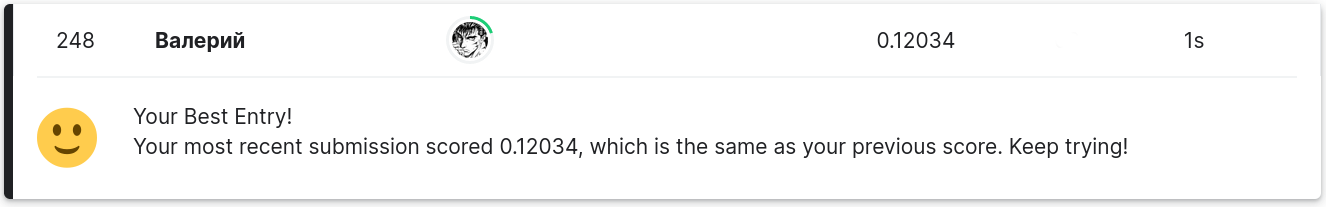

In [8]:
Image('./assets/Screenshot.png')